In [132]:
import numpy as np
from pylab import *
from craco.cardcap import CardcapFile
from astropy.io import fits
from craft.craftcor import MiriadGainSolutions
import glob
from craco.search_pipeline import location2pix, get_grid_lut_from_plan, grid_candidates,wait_for_starts,waitall,print_candidates
from craco.search_pipeline import NBINARY_POINT_FDMTIN 
import craco
import craco.search_pipeline
from craco.pyxrtutil import *
import craft.craco_plan

from craft import uvfits

from craft.craco_plan import PipelinePlan
from craft.craco import printstats,bl2ant
import logging
import time
import scipy
import h5py

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Copy from pawsey with $ rsync -avz -e 'ssh -A -J venice.atnf.csiro.au' galaxy.pawsey.org.au:/group/askap/elenc/crap.tgz SB43768_summary.tgz  --progress

In [133]:
cd /data/craco/ban115/craco-python/notebooks/data/SB43768/group/askaprt/mos078/vamplots-askap/results/


/data/craco/ban115/craco-python/notebooks/data/SB43768/group/askaprt/mos078/vamplots-askap/results


In [210]:
cd /data/craco/ban115/craco-python/notebooks/data/SB46073 # CRACO firmware

/data/craco/ban115/craco-python/notebooks/data/SB46073


In [230]:
cd /data/craco/ban115/craco-python/notebooks/data/SB46076 

/data/craco/ban115/craco-python/notebooks/data/SB46076


In [231]:
ls -lh

total 2.3G
-rw-r----- 1 ban115 ban115   642 Dec 10 03:41 2022-12-09_084910_744MHz.pickle
-rw-r----- 1 ban115 ban115   642 Dec 10 03:41 2022-12-09_084910_792MHz.pickle
-rw-r----- 1 ban115 ban115   642 Dec 10 03:41 2022-12-09_084910_840MHz.pickle
-rw-r----- 1 ban115 ban115   642 Dec 10 03:41 2022-12-09_084910_888MHz.pickle
-rw-r----- 1 ban115 ban115   642 Dec 10 03:41 2022-12-09_084910_936MHz.pickle
-rw-r----- 1 ban115 ban115   643 Dec 10 03:41 2022-12-09_084910_984MHz.pickle
-rw-r----- 1 ban115 ban115  5.6M Dec 10 06:10 2022-12-09_084910_ampantbeam_waterfall_autoscale_744MHz_XX.png
-rw-r----- 1 ban115 ban115  5.8M Dec 10 06:10 2022-12-09_084910_ampantbeam_waterfall_autoscale_744MHz_YY.png
-rw-r----- 1 ban115 ban115  5.6M Dec 10 06:02 2022-12-09_084910_ampantbeam_waterfall_autoscale_791MHz_XX.png
-rw-r----- 1 ban115 ban115  5.5M Dec 10 06:21 2022-12-09_084910_ampantbeam_waterfall_autoscale_791MHz_YY.png
-rw-r----- 1 ban115 ban115  5.7M Dec 10 06:12 2022-12-09_084910_ampantbeam_waterfall_

In [232]:
allfiles = glob.glob('*.h5')
f0 = allfiles[0]
h = h5py.File(f0)

In [233]:
h.attrs.keys()

<KeysViewHDF5 []>

In [234]:
h.keys()

<KeysViewHDF5 ['B00', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'B33', 'B34', 'B35']>

In [235]:
b0 = h['B00']

In [236]:
b0.keys()

<KeysViewHDF5 ['amplitude', 'antennas', 'ants1', 'ants2', 'baselines', 'freqaxis', 'freqs', 'phase', 'timestamps']>

In [237]:
b0['amplitude'].keys()

<KeysViewHDF5 ['ampchan_median', 'ampmatrices_auto', 'amptime_median']>

In [238]:
b0['amplitude/ampmatrices_auto']

<HDF5 dataset "ampmatrices_auto": shape (36, 77, 108), type "<f8">

In [239]:
b0['amplitude/amptime_median']

<HDF5 dataset "amptime_median": shape (595, 77), type "<f8">

In [240]:
b0['amplitude/ampchan_median']

<HDF5 dataset "ampchan_median": shape (595, 108), type "<f8">

In [241]:
!ls *_XX.h5

2022-12-09_084910_c0_XX.h5  2022-12-09_084910_c3_XX.h5
2022-12-09_084910_c1_XX.h5  2022-12-09_084910_c4_XX.h5
2022-12-09_084910_c2_XX.h5  2022-12-09_084910_c5_XX.h5


In [242]:
xx_files = sorted(filter(lambda f: 'XX' in f, allfiles))
xx_files
xx_files = allfiles

<IPython.core.display.Javascript object>


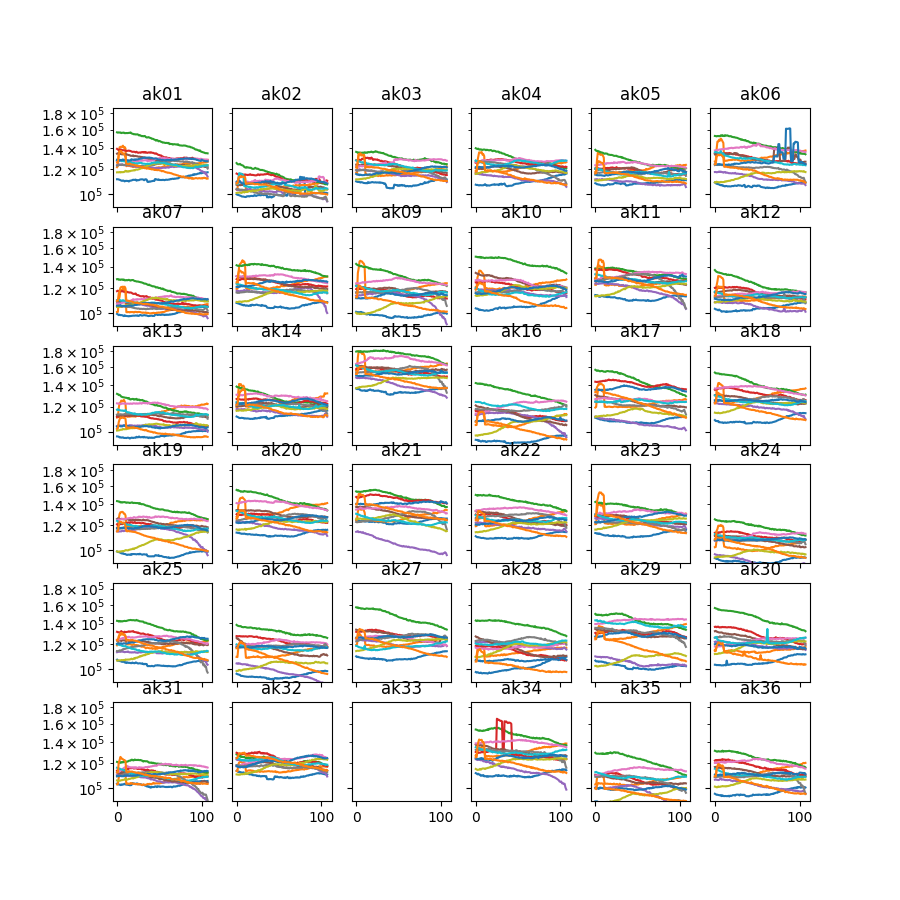

In [243]:

fig,ax = subplots(6,6, sharex=True, sharey=True)
fig.set_size_inches((9,9))
lines = []
for fname in xx_files:
    h = h5py.File(fname)
    b0 = h['B00']
    d = b0['amplitude/ampmatrices_auto']
    ax = ax.flatten()
    
    for b in range(36):
        #ax[b].imshow(d[b,:,:], aspect='auto', origin='lower')
        l, = ax[b].semilogy(d[b,:,:].max(axis=0))
        if (b == 0):
            lines.append(l)
            
        ax[b].set_title(f'ak{b+1:02d}')
        
#fig.figlegend(lines)

<IPython.core.display.Javascript object>


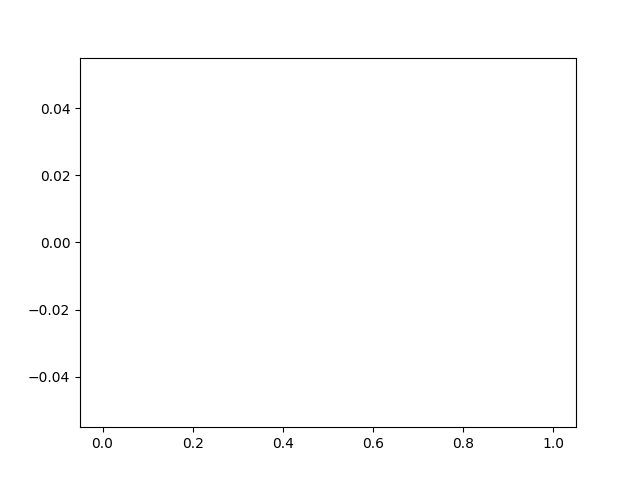

In [245]:
figure()

for c, fname in enumerate(xx_files):
    h = h5py.File(fname)
    b0 = h['B00']
    d = b0['amplitude/ampmatrices_auto']
    x = d[:].flatten()
    hist(x[x>1e6], bins=100,label=f'Shelf {c}')
    ax = ax.flatten()
    for b in range(36):
        #ax[b].imshow(d[b,:,:], aspect='auto', origin='lower')
        x = d[b,:,:].flatten()
        ax[b].hist(x[x>1e6])


In [246]:
threshold = 1e6
npol = 2
nblock = 6
nant = 36
nbeam = 36
nchan = 2592
badcount = np.zeros((nbeam, npol, nant, nblock, nchan), dtype=np.int)
for ipol, pol in enumerate(['XX','YY']):
    files = sorted(filter(lambda f: pol in f, allfiles))
    for c, fname in enumerate(files):
        h = h5py.File(fname)
        for b in range(36):
            d = h[f'B{b:02d}/amplitude/ampmatrices_auto']
            badcount[b,ipol,:,c,:] = (d[:] > threshold).sum(axis=1)
        h.close()

ValueError: could not broadcast input array from shape (36,108) into shape (36,2592)

In [ ]:
badcount.shape # (beam, pol, ant, block, channel)

In [ ]:
fig,ax = subplots(6,6, sharex=True, sharey=True)
fig.set_size_inches((9,9))
beam=0
pol=0
ax = ax.flatten()
for block in range(nblock):
    for ant in range(nant):
        l, = ax[ant].plot(badcount[:,pol,ant,block,:].sum(axis=0))        
        ax[ant].set_title(f'ak{ant+1:02d}')

In [ ]:
fig,ax = subplots(6,6, sharex=True, sharey=True)
fig.set_size_inches((9,9))
beam=0
pol=0
ax = ax.flatten()
for block in range(nblock):
    for ant in range(nant):
        l, = ax[ant].plot(badcount[:,pol,ant,block,:].sum(axis=1))        
        ax[ant].set_title(f'ak{ant+1:02d}')

In [154]:
badcount.shape # (beam, pol, ant, block, channel)

(36, 2, 36, 6, 2592)

<IPython.core.display.Javascript object>


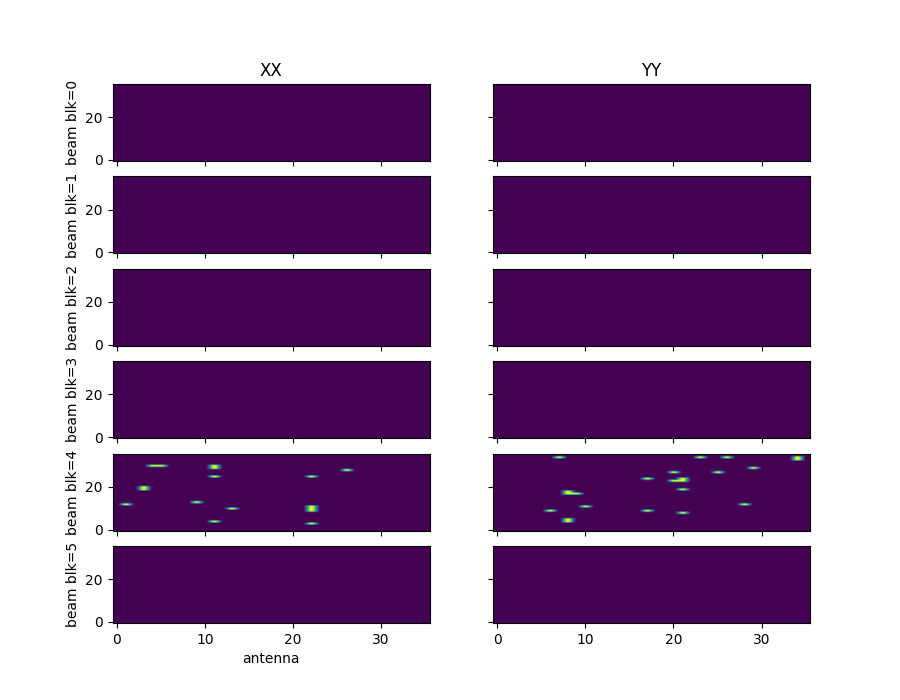

Text(0.5, 1.0, 'YY')

In [161]:
fig,ax = subplots(6,2, sharex=True, sharey=True)
fig.set_size_inches((9,7))
chanrange = slice(2210,2220) # bad one in my block 4
#chanrange=slice(None)
for block in range(nblock):
    ax[block,0].set_ylabel(f'beam blk={block}')
    for pol in range(npol):
        ax[block,pol].imshow(badcount[:,pol,:,block,chanrange].sum(axis=2),aspect='auto',origin='lower')
        
        
ax[-1,0].set_xlabel('antenna')
ax[0,0].set_title('XX')
ax[0,1].set_title('YY')

<IPython.core.display.Javascript object>


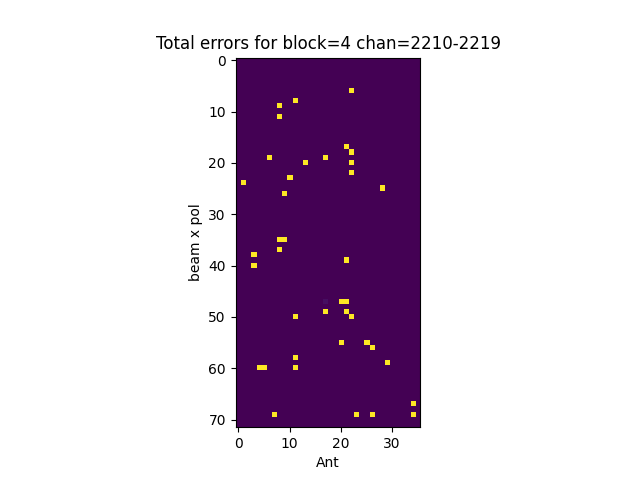

Text(0.5, 1.0, 'Total errors for block=4 chan=2210-2219')

In [163]:
figure()
block=4
badd = badcount[:,:,:,block,chanrange].sum(axis=3)
badd.shape # (beam, pol, ant)
imshow(badd.reshape(72,36))
ylabel('beam x pol')
xlabel('Ant')
title(f'Total errors for block={block} chan={chanrange.start}-{chanrange.stop-1}')



In [164]:
newshape = list(badcount.shape[:-1])
 # (6 fpgas, 4 coarse channels, 9 fine channels)
ncard = 12
nfpga = 6
ncoarse = 4
nfine = 9
newshape.extend([ncard, ncoarse, nfpga, nfine])
badcountf = badcount.copy().reshape(newshape)
badcountf.shape # (beam, pol, ant, block, card, coarse, fpga, fine)

(36, 2, 36, 6, 12, 4, 6, 9)

In [165]:
badcountfd = badcountf.reshape([nbeam, npol, nant, nblock*ncard, ncoarse, nfpga, nfine])
badcountfd.shape # (beam, pol, ant, block* card, coarse, fpga, fine)

(36, 2, 36, 72, 4, 6, 9)

<IPython.core.display.Javascript object>


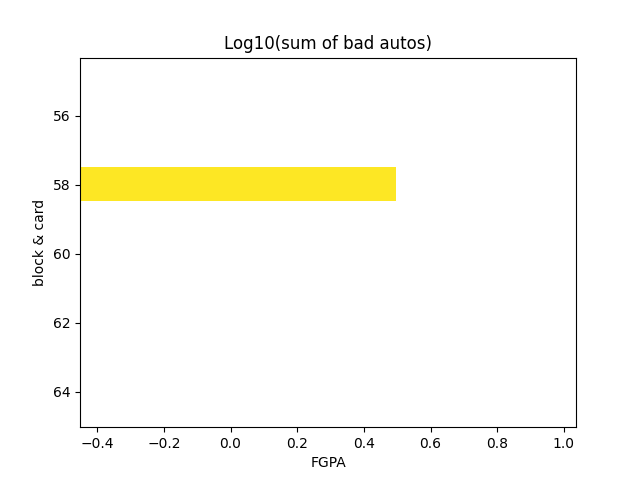

/data/craco/ban115/craco-python/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5, 1.0, 'Log10(sum of bad autos)')

In [166]:
figure()
imshow(np.log10(np.sum(badcountfd, axis=(0,1,2,4,6))), aspect='auto')
xlabel('FGPA')
ylabel('block & card')
title('Log10(sum of bad autos)')

In [167]:
badcountfd.shape

(36, 2, 36, 72, 4, 6, 9)

In [178]:
bad_blockcard = 58
bad_fpgano = 0

#badfpga = badcountfd[:,:,:,45,:,4,:] # The really bad one
badfpga = badcountfd[:,:,:,bad_blockcard,:,bad_fpgano,:] # The next bad one
badfpga.shape  # (beam, pol, ant,  coarse,  fine)

(36, 2, 36, 4, 9)

In [179]:
def plot_transpose(badfpga, transpose, label):
    fig,ax = subplots(1,2,sharex=True,sharey=True)
    d = np.transpose(badfpga, transpose)
    #d = badfpga
    fig.set_size_inches((9,5))
    ax[0].imshow(d[:,0,...].reshape(36, 36*4*9), aspect='auto')
    ax[1].imshow(d[:,1,...].reshape(36, 36*4*9), aspect='auto')
    ax[0].set_title('XX')
    ax[1].set_title('YY')
    ax[0].set_ylabel('beam')
    ax[0].set_xlabel(label)
    

<IPython.core.display.Javascript object>


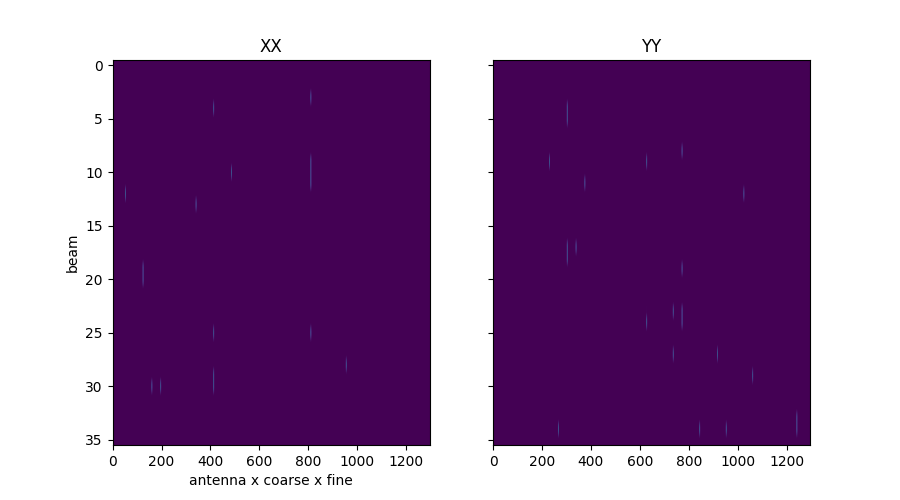

In [181]:
plot_transpose(badfpga, (0,1,2,3,4), 'antenna x coarse x fine')

<IPython.core.display.Javascript object>


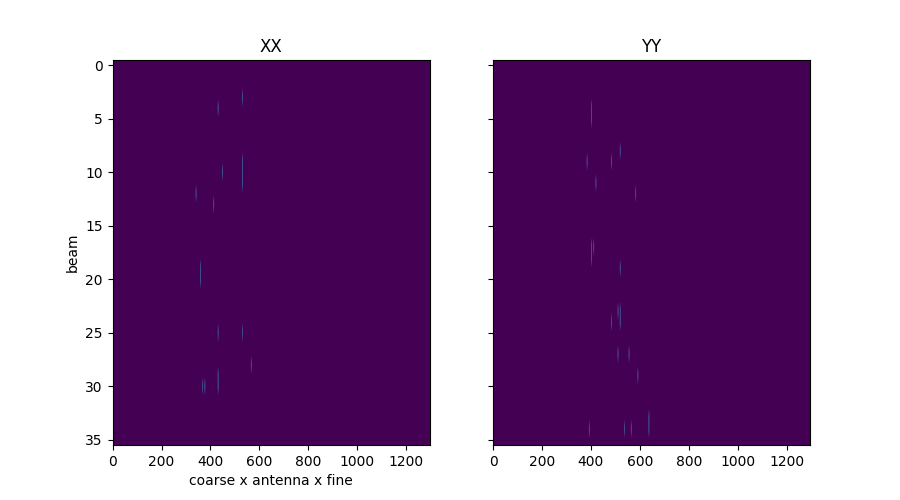

In [182]:
plot_transpose(badfpga, (0,1,3,2,4), 'coarse x antenna x fine')

In [183]:
badfpga.shape # (beam, pol, ant,  coarse,  fine)

(36, 2, 36, 4, 9)

<IPython.core.display.Javascript object>


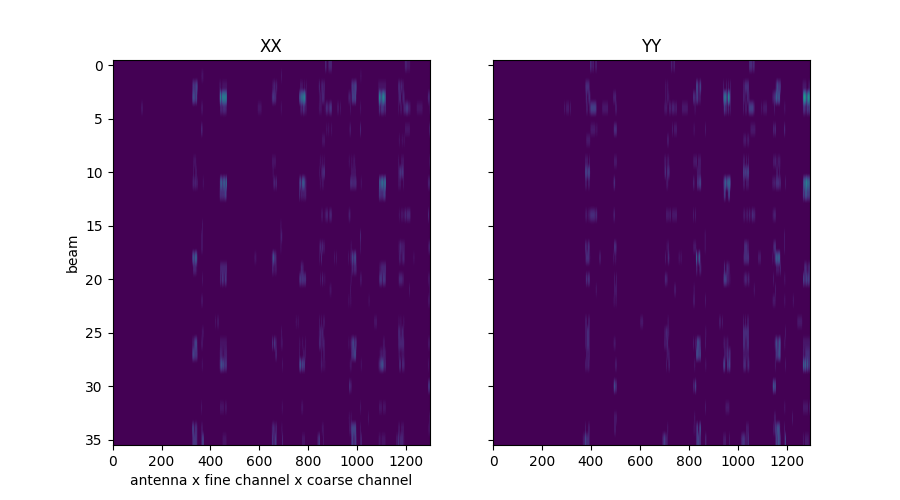

In [32]:
plot_transpose(badfpga, (0,1,2,4,3), 'antenna x fine channel x coarse channel')

In [184]:
badcountfd.shape # (beam, pol, ant, block* card, coarse, fpga, fine)

(36, 2, 36, 72, 4, 6, 9)

In [185]:
badcountfd_afc = np.transpose(badcountfd, [0,1,3,5,2,6,4])
badcountfd_afc.shape # beam, pol, block*card,fpga, ant, fine, coarse

(36, 2, 72, 6, 36, 9, 4)

<IPython.core.display.Javascript object>


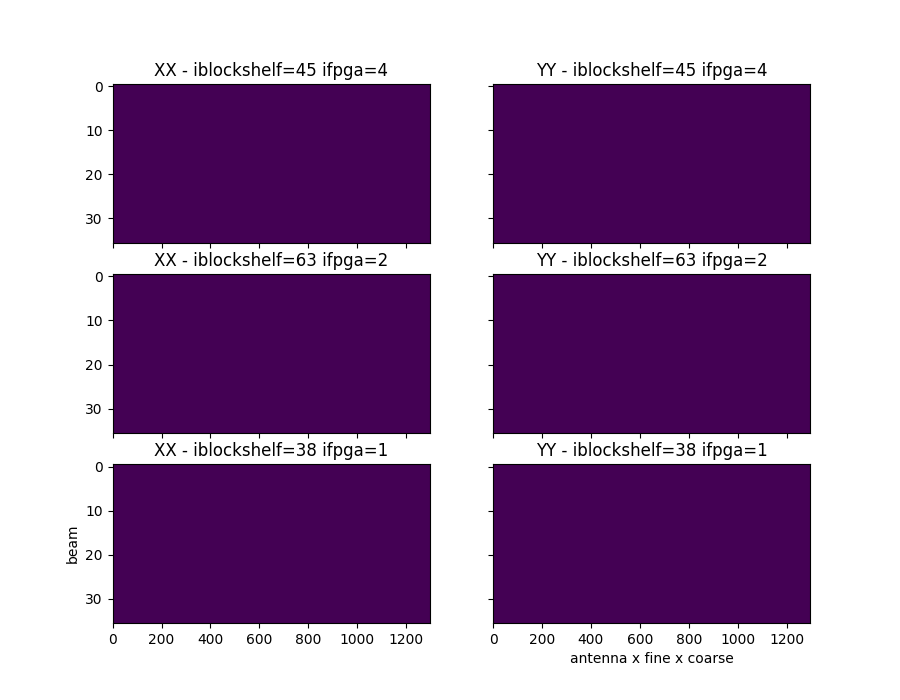

Text(0.5, 0, 'antenna x fine x coarse')

In [186]:
#badfpga = badcountfd[:,:,:,45,:,4,:] # The really bad one
#badfpga = badcountfd[:,:,:,63,:,2,:] # The next bad one
bad_devices = [(45,4),(63,2),(38,1)]
#bad_devices = bad_devices[0:1]
def myplot(ax,d):
    ax.imshow(d.reshape(36,-1), aspect='auto')
    
fig,ax = subplots(len(bad_devices),2,sharex=True,sharey=True, squeeze=False)
fig.set_size_inches((9,7))
    
for idev, (iblockshelf, ifpga) in enumerate(bad_devices):
    myplot(ax[idev,0], badcountfd_afc[:,0,iblockshelf,ifpga,...])
    myplot(ax[idev,1], badcountfd_afc[:,1,iblockshelf,ifpga,...])
    ax[idev,0].set_title(f'XX - iblockshelf={iblockshelf} ifpga={ifpga}')
    ax[idev,1].set_title(f'YY - iblockshelf={iblockshelf} ifpga={ifpga}')

ax[-1,0].set_ylabel('beam')
ax[-1,1].set_xlabel('antenna x fine x coarse')

In [189]:
badcountfd_afc.shape # beam, pol, block*card,fpga, ant, fine, coarse

(36, 2, 72, 6, 36, 9, 4)

In [190]:
torder = np.transpose(badcountfd_afc, (2,3,6,0,4,1,5))
torder.shape # block*card, fpga, coarse, beam, nant, npol, nfine

(72, 6, 4, 36, 36, 2, 9)

In [191]:
torder = torder.reshape((72,6,4*36,36,2,9))
torder.shape # block*card, fpga, coarse*beam, nant, npol, nfine

(72, 6, 144, 36, 2, 9)

<IPython.core.display.Javascript object>


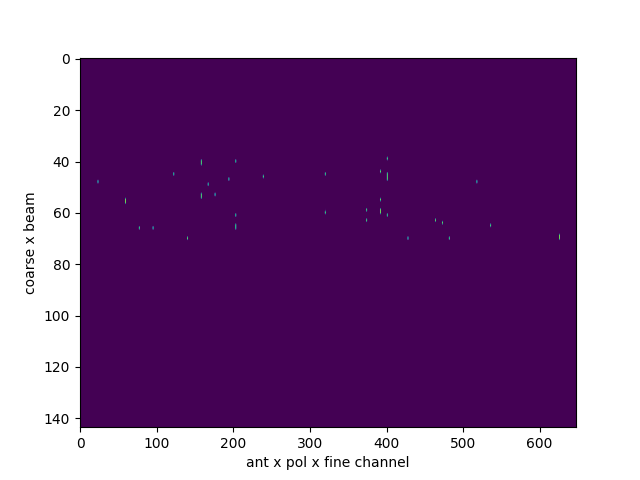

Text(0, 0.5, 'coarse x beam')

In [198]:
figure()
imshow(torder[bad_blockcard,bad_fpgano,:,...].reshape(144,-1),aspect='auto')
xlabel('ant x pol x fine channel')
ylabel('coarse x beam')

In [194]:
sigs = []

bout = 0
cout = 0
permute_idxs = []
for inc in range(4):
    for inb in range(32):
        idx = inb + inc*36
        permute_idxs.append(idx)
        sigs.append((inc, inb, cout, bout,idx))

        if bout == 35:
            cout = (cout + 1) % 4
            
        bout = (bout + 1) % 36       
        
        
for inc in range(4):
    for inb in range (32,36):
        idx = inb + inc*36

        permute_idxs.append(idx)
        sigs.append((inc, inb, cout,bout,idx))

        if bout == 35:
            cout = (cout + 1) % 4            
        bout = (bout + 1) % 36
        
#sigs

In [199]:
bad = torder[bad_blockcard,bad_fpgano,...].reshape(4*36,36,2,9)
bad.shape


(144, 36, 2, 9)

In [200]:
bad_border = bad[permute_idxs,...]

<IPython.core.display.Javascript object>


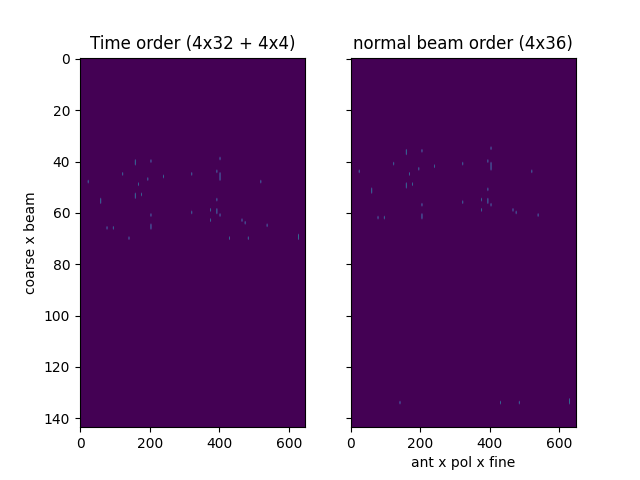

Text(0.5, 0, 'ant x pol x fine')

In [201]:
fig,ax = subplots(1,2,sharex=True, sharey=True)
ax[0].imshow(bad.reshape(144,-1), aspect='auto')
ax[1].imshow(bad_border.reshape(144,-1),aspect='auto')
ax[0].set_title('Time order (4x32 + 4x4)')
ax[1].set_title('normal beam order (4x36)')
ax[0].set_ylabel('coarse x beam')
ax[1].set_xlabel('ant x pol x fine')

<IPython.core.display.Javascript object>


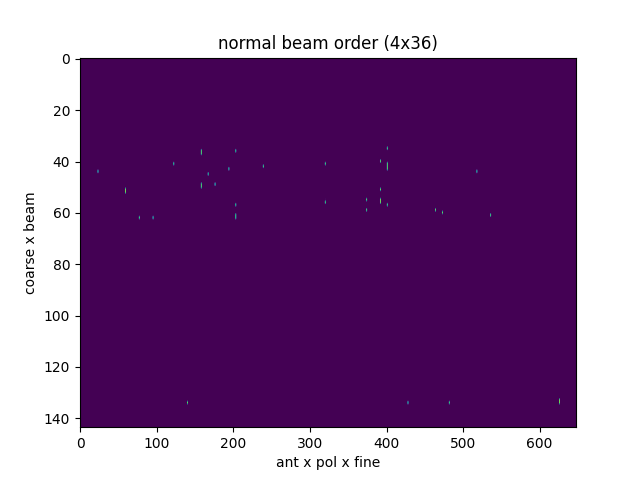

Text(0.5, 0, 'ant x pol x fine')

In [202]:
fig,ax = subplots(1,1,sharex=True, sharey=True)
ax = [ax]
ax[0].imshow(bad_border.reshape(144,-1),aspect='auto')
ax[0].set_title('normal beam order (4x36)')
ax[0].set_ylabel('coarse x beam')
ax[0].set_xlabel('ant x pol x fine')

<IPython.core.display.Javascript object>


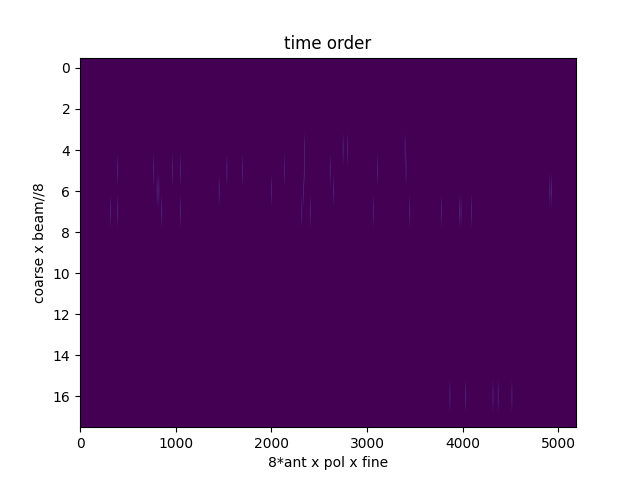

Text(0.5, 0, '8*ant x pol x fine')

In [203]:
fig,ax = subplots(1,1,sharex=True, sharey=True)
ax = [ax]
ax[0].imshow(bad_border.reshape(144//8,-1),aspect='auto')
ax[0].set_title('coarse x beam order')
ax[0].set_title('time order')
ax[0].set_ylabel('coarse x beam//8')
ax[0].set_xlabel('8*ant x pol x fine')

<IPython.core.display.Javascript object>


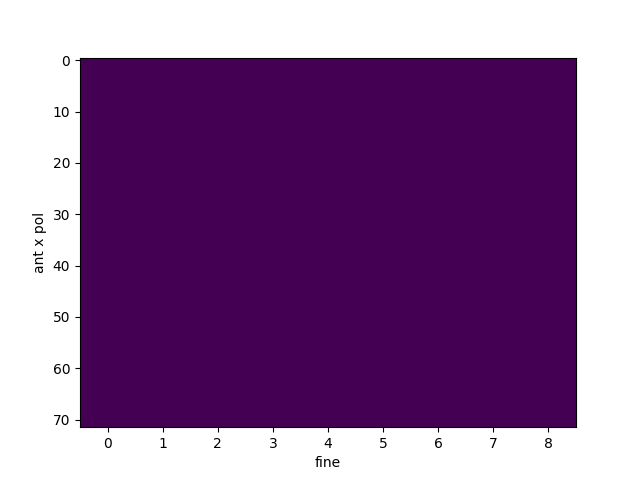

Text(0.5, 0, 'fine')

In [204]:
figure()
imshow(bad_border[3,...].reshape(36*2,-1),aspect='auto')
ylabel('ant x pol')
xlabel('fine')

In [206]:
# pick out a bad one of the beamchans and reshape to nant*npol x nfine
badbeam = bad_border[3,...].reshape(nant*npol,nfine)
badbeam.shape

(72, 9)

<IPython.core.display.Javascript object>


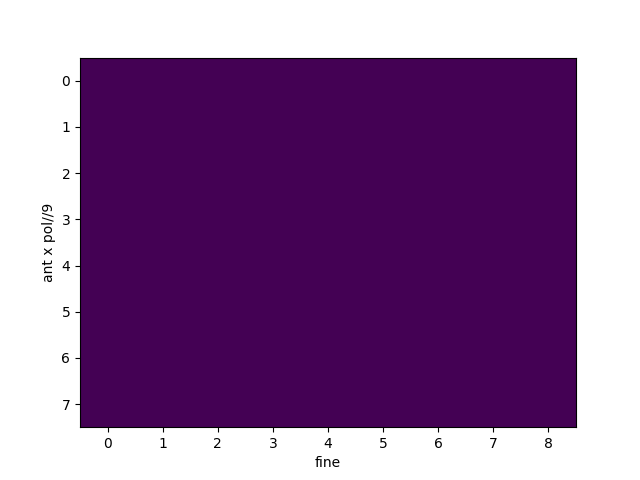

Text(0.5, 0, 'fine')

In [207]:
figure()
imshow(badbeam[7::9,...],aspect='auto')
ylabel('ant x pol//9')
xlabel('fine')

When you look at the cell ordering diagram it's clear that when going through the corr cell products, when row==column you'll get autos for 9 fine freqs. All the cells are very close together (searated by a few clocks) so basically all autos from the top left corner (pos=0,0) come out withing a few clocks, then loop over different fine freqs, then a big gap while you go through 10 more cells, then all autos from pos=1,1 and so on. pos=0,0 for all the cells is Ant1A for cell 00, Ant5B for cell 1,1, Ant 10A for cell 2,2 etc. Basically if you stack all teh ants and pols together, it comes together in groups of 9.

In [208]:
# So let's re-order in groups of 9 - leave the fine channel axis alone.
badbeam_torder = np.transpose(badbeam.reshape((8,9,nfine)), (1,0,2)).reshape(nant*npol,nfine)

<IPython.core.display.Javascript object>


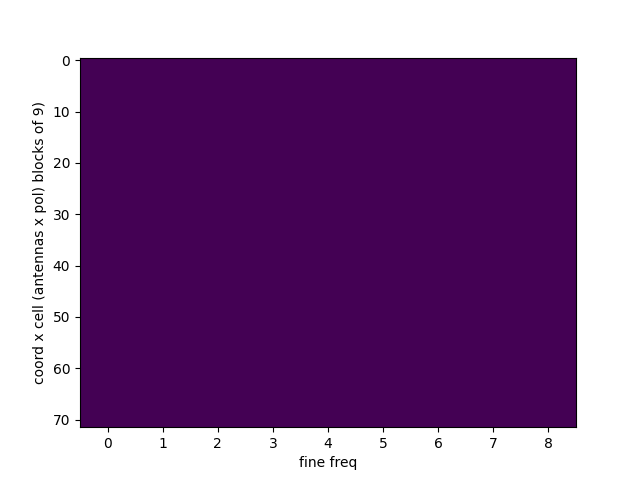

Text(0, 0.5, 'coord x cell (antennas x pol) blocks of 9)')

In [209]:
figure()
imshow(badbeam_torder, aspect='auto')
xlabel('fine freq')
ylabel('coord x cell (antennas x pol) blocks of 9)')

# Try to understand what the floof is going on with the antenna axis - let's get stuff from pawsey

In [51]:
#!rsync -avz -e 'ssh -J venice' --progress galaxy.pawsey.org.au:/group/askap/glo049/CRACO/43768/subband .

In [52]:
#!rsync -avz -e 'ssh -J venice' --progress galaxy.pawsey.org.au:/group/askap/glo049/CRACO/43768/lsm_cal/43768_mslist.csv .

In [53]:
cd /data/craco/ban115/craco-python/notebooks/data/SB45380

/data/craco/ban115/craco-python/notebooks/data/SB45380


In [54]:
import pandas as pd
import glob
pd.set_option('display.max_colwidth',None)

In [55]:
mslist = pd.read_csv(glob.glob('*_mslist.csv')[0])

In [56]:
mslist['freq'].unique()

array([744, 791, 839, 887, 935, 983])

In [57]:
# mslist[mslist['freq'] == 943] # SB43768
mslist = mslist[mslist['freq'] == 791]
mslist

freq  beam  \
36   791     0   
37   791     1   
38   791     2   
39   791     3   
40   791     4   
41   791     5   
42   791     6   
43   791     7   
44   791     8   
45   791     9   
46   791    10   
47   791    11   
48   791    12   
49   791    13   
50   791    14   
51   791    15   
52   791    16   
53   791    17   
54   791    18   
55   791    19   
56   791    20   
57   791    21   
58   791    22   
59   791    23   
60   791    24   
61   791    25   
62   791    26   
63   791    27   
64   791    28   
65   791    29   
66   791    30   
67   791    31   
68   791    32   
69   791    33   
70   791    34   
71   791    35   

                                                                        path  
36   /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_1.ms  
37  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_41.ms  
38  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_42.ms  
39  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_43.ms  
40  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_44.ms  
41  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_45.ms  
42  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_46.ms  
43  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_47.ms  
44  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_48.ms  
45  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_49.ms  
46  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_50.ms  
47  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_51.ms  
48  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_52.ms  
49  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_53.ms  
50  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_54.ms  
51  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_55.ms  
52  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_56.ms  
53  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_57.ms  
54  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_58.ms  
55  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_59.ms  
56  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_60.ms  
57  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_61.ms  
58  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_62.ms  
59  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_63.ms  
60  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_64.ms  
61  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_65.ms  
62  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_66.ms  
63  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_67.ms  
64  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_68.ms  
65  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_69.ms  
66  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_70.ms  
67  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_71.ms  
68  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_72.ms  
69  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_73.ms  
70  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_74.ms  
71  /askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_75.ms

In [58]:
from casatools import ms

In [59]:
from casacore.tables import *


In [60]:
mslist['path'].iloc[0]
msfile = mslist['path'].iloc[0][1:]
msfile

'askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_1.ms'

In [61]:
t = table(msfile)

Successful readonly open of default-locked table askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_1.ms: 22 columns, 19980 rows


In [62]:

nant = 36
nbl=nant*(nant+1)//2
tstart = nbl*20
a1 = t.getcol('ANTENNA1', startrow=tstart, nrow=nbl)
a2 = t.getcol('ANTENNA2', startrow=tstart, nrow=nbl)
d = t.getcol('DATA', startrow=tstart, nrow=nbl)

<IPython.core.display.Javascript object>


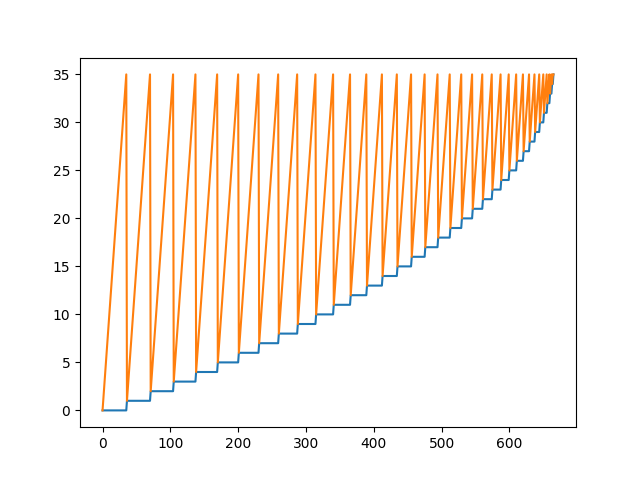

In [63]:
figure()
plot(a1)
plot(a2)

In [64]:
d.shape

(666, 2592, 4)

In [65]:
t.nrows()

19980

<IPython.core.display.Javascript object>


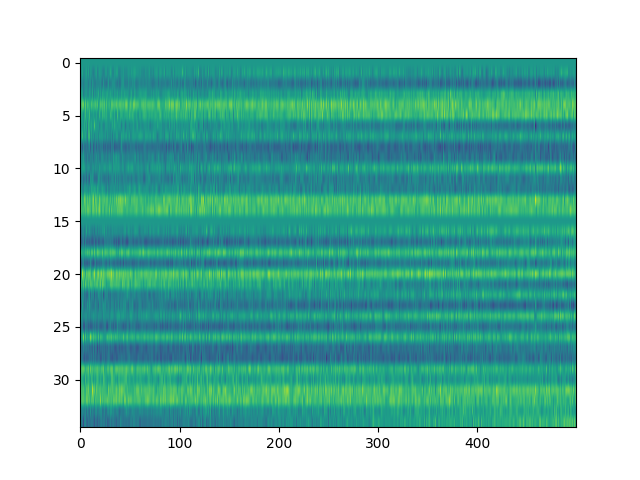

In [66]:
figure()
imshow(d[0:35,0:500,3].imag,aspect='auto')

In [67]:
myms = ms()
#msfile = 'subband/2022-09-07_025714_121.ms'

In [68]:
myms.open(msfile)

True

In [69]:
myms.summary()

{'BeginTime': 59887.25520683108,
 'EndTime': 59887.25866283109,
 'IntegrationTime': 298.5984001159668,
 'field_0': {'code': '',
  'direction': {'m0': {'unit': 'rad', 'value': -1.1370073948487838},
   'm1': {'unit': 'rad', 'value': -1.1249538538554333},
   'refer': 'J2000',
   'type': 'direction'},
  'name': 'B1934-638_beam0'},
 'nfields': 1,
 'numrecords': 19980,
 'scan_0': {'0': {'BeginTime': 59887.25520683108,
   'EndTime': 59887.25866283109,
   'FieldId': 0,
   'FieldName': 'B1934-638_beam0',
   'IntegrationTime': 9.953279999999852,
   'SpwIds': array([0]),
   'StateId': -1,
   'nRow': 19980,
   'scanId': 0}},
 'timeref': 'UTC'}

In [70]:
myms.close()



True

In [71]:
def calc_dcount(msfile, nbl=666, threshold=1e6):
    t = table(msfile)
    nrows = t.nrows()
    assert nrows % nbl == 0
    nchunks = nrows // nbl
    dcount = None
    for chunk in range(nchunks):
        tstart = nbl*chunk
        if chunk % 100 == 99:
            print(f'Chunk {chunk}/{nchunks}')
        d = t.getcol('DATA',startrow=tstart, nrow=nbl)
        if dcount is None:
            dcount = np.zeros_like(d)
            
        dcount.real += (d.real > threshold)
        dcount.imag += (d.imag > threshold)
        
    return dcount
        

In [72]:
dcount = calc_dcount(msfile)

Successful readonly open of default-locked table askapbuffer/scott/askap-scheduling-blocks/45380/2022-11-04_060755_1.ms: 22 columns, 19980 rows


In [73]:
#!pip install ipyparallel
import ipyparallel as ipp

In [74]:
# jupyter nbotebook died doing this, might need to work out another way.


def load_beam(task):
    import os
    from casacore.tables import table
    import numpy as np

    def calc_dcount(msfile, nbl=666, threshold=1e6):
        t = table(msfile)
        nrows = t.nrows()
        assert nrows % nbl == 0
        nchunks = nrows // nbl
        dcount = None
        for chunk in range(nchunks):
            tstart = nbl*chunk
            if chunk % 100 == 99:
                print(f'Chunk {chunk}/{nchunks}')
            d = t.getcol('DATA',startrow=tstart, nrow=nbl)
            if dcount is None:
                dcount = np.zeros_like(d)

            dcount.real += (d.real > threshold)
            dcount.imag += (d.imag > threshold)

        return dcount
    
    index, row = task
    mspath = row['path'][1:]  
    beam_dcount = calc_dcount(mspath)
    return beam_dcount

def load_all_beams():
    import os
    task_list = list(mslist.iterrows())
    #print(task_list)
    print(f'Got {len(task_list)} tasks')
    with ipp.Cluster(n=8) as rc:
        view = rc.load_balanced_view()
        asyncresult = view.map_async(load_beam, task_list)
        asyncresult.wait_interactive()
        bdmax = asyncresult.get()
        

        
    return bdmax
        
import os
if os.path.exists('bdmax.npy'):
    bdmax = np.load('bdmax.npy')
else:
    bdmax = load_all_beams()
    bdmax = np.array(bdmax)
    np.save('bdmax.npy', bdmax)

In [75]:
!ls -hl bdmax.npy

-rw-rw-r-- 1 ban115 ban115 1.9G Nov  9 08:00 bdmax.npy


In [76]:
bdmax.shape

(36, 666, 2592, 4)

/data/craco/ban115/craco-python/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


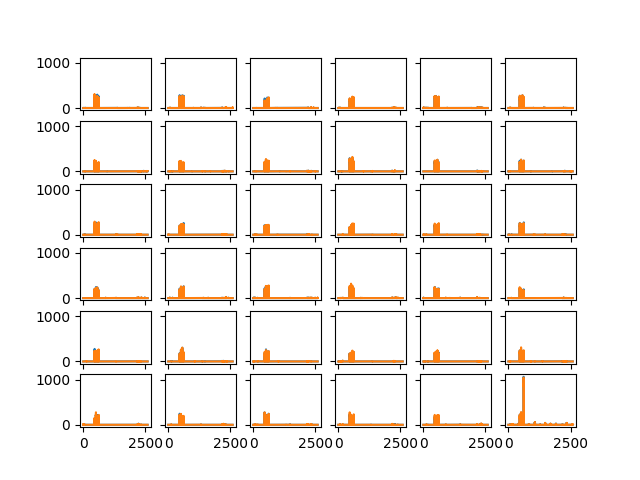

In [77]:
fig, ax = subplots(6,6, sharex=True, sharey=True)
ax = ax.flatten()
for b in range(36):
    #ax[b].imshow(bdmax[b, :, :, 0].real, aspect='auto', origin='lower')
    ax[b].plot(bdmax[b,:,:,0].sum(axis=0).real)
    ax[b].plot(bdmax[b,:,:,0].sum(axis=0).imag)

In [78]:
bdmax.shape

(36, 666, 2592, 4)

<IPython.core.display.Javascript object>


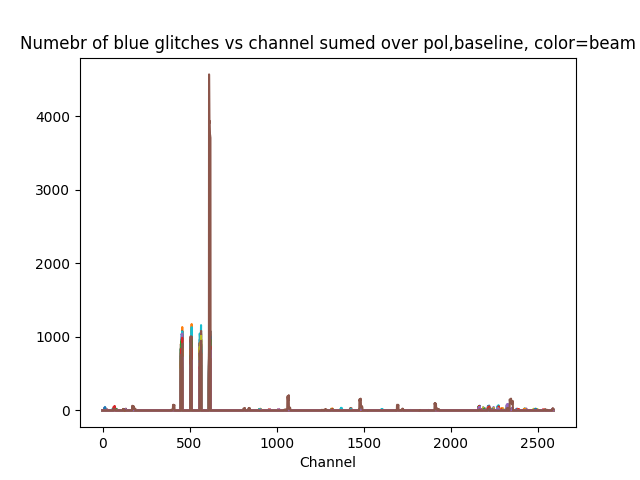

Text(0.5, 1.0, 'Numebr of blue glitches vs channel sumed over pol,baseline, color=beam')

In [79]:
figure()
_ = plot(bdmax.real.sum(axis=(1,3)).T)
xlabel('Channel')
title('Numebr of blue glitches vs channel sumed over pol,baseline, color=beam')

In [80]:
bdmax.shape

(36, 666, 2592, 4)

<IPython.core.display.Javascript object>


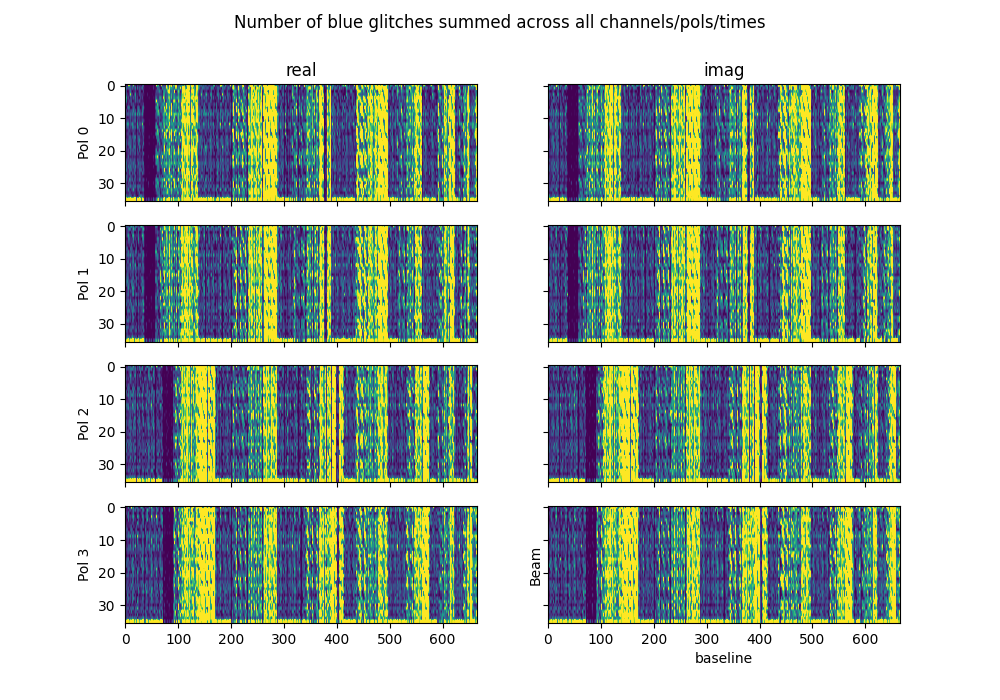

Text(0.5, 1.0, 'imag')

In [81]:
fig,ax = subplots(4,2, sharex=True, sharey=True)
gcf().set_size_inches((10,7))
chanrange = slice(None,None)
#chanrange=slice(1466,1466+9+1)
#chanrange=slice(2268,2268+9+1)
#chanrange=slice(1052,1052+9+1)

vmax = 20
for pol in range(4):
    ax[pol, 0].imshow(bdmax[:,:,chanrange,pol].real.sum(axis=(2)), aspect='auto', vmax=vmax)
    ax[pol, 1].imshow(bdmax[:,:,chanrange,pol].imag.sum(axis=(2)), aspect='auto', vmax=vmax)
    ax[pol, 0].set_ylabel(f'Pol {pol}')
xlabel('baseline')
ylabel('Beam')
suptitle('Number of blue glitches summed across all channels/pols/times')
ax[0,0].set_title('real')
ax[0,1].set_title('imag')

<IPython.core.display.Javascript object>


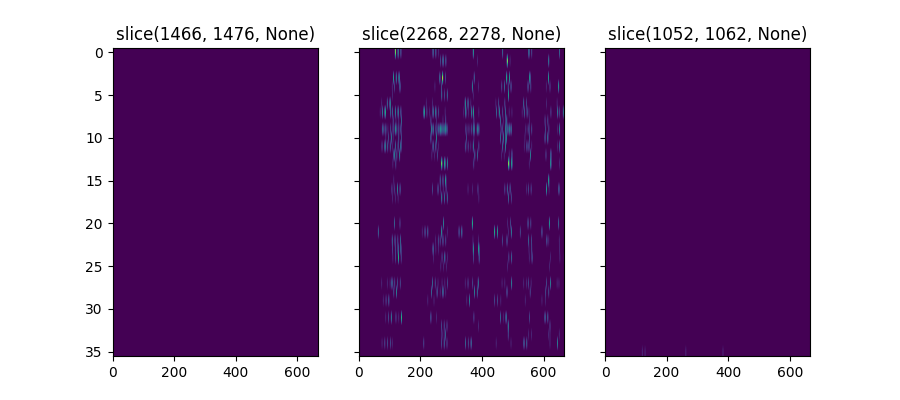

In [82]:
chanranges=[slice(1466,1466+9+1),slice(2268,2268+9+1),slice(1052,1052+9+1)]
fig, ax = subplots(1,3, sharex=True, sharey=True)
fig.set_size_inches((9,4))
vmax=3
for i in range(3):
    pol=0
    ax[i].imshow(bdmax[:,:,chanranges[i],pol].real.sum(axis=(2)), aspect='auto', vmax=vmax)
    ax[i].set_title(str(chanranges[i]))

In [83]:

bdmax.shape

(36, 666, 2592, 4)

In [84]:
bdcard = bdmax.reshape((36,666,ncard,ncoarse,nfpga,nfine,4))
bdcard.shape # nbeam, nbl, ncard, ncoarse, nfpga, nfine, npolout

(36, 666, 12, 4, 6, 9, 4)

<IPython.core.display.Javascript object>


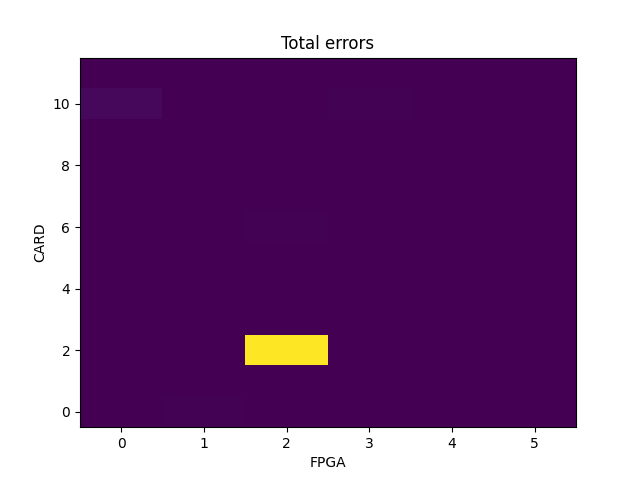

Text(0.5, 1.0, 'Total errors')

In [85]:
figure()
imshow(bdcard.sum(axis=(0,1,3,5,6)).real + bdcard.sum(axis=(0,1,3,5,6)).imag, aspect='auto', origin='lower')
xlabel('FPGA')
ylabel('CARD')
title('Total errors')


In [86]:
icard = 10
ifpga = 0

icard = 4
ifpga = 3

icard = 2
ifpga = 2

In [87]:
# bdcard.shape # nbeam, nbl, ncard, ncoarse, nfpga, nfine, npolout
bdfpga = bdcard[:,:,icard,:,ifpga,:,:]
bdfpga.shape # nbeam, nbl, ncoarse, nfine, npolout

(36, 666, 4, 9, 4)

<IPython.core.display.Javascript object>


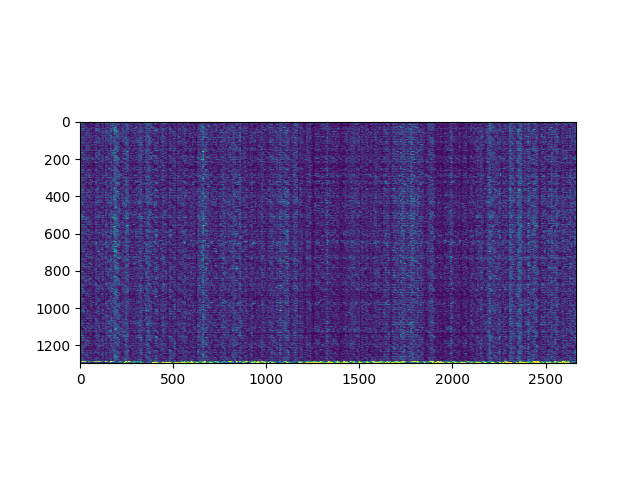

In [88]:
figure()
imshow(bdfpga.transpose((2,0,4,1,3)).reshape(36*4*9,-1).real, vmax=2)

In [89]:
# do readout
from craco.correlator_cells import CorrelatorCells, ibc2beamchan, READOUT_CLK
cells = CorrelatorCells()

In [100]:
readout = np.zeros((4,36*4, 9,9,9,9,2)) # (lane, beam, icy, icx, nfinechan, clk, complx)

for lane in range(4):
    for ibc in range(36*4):
        beam, chan = ibc2beamchan(ibc)
        print(ibc, beam, chan, lane)
        for icy in range(9):
            for icx in range(9):
                for ifreq in range(9):
                    for clk in range(9):
                        xcell, ycell = READOUT_CLK[clk,lane,:]
                        a1,p1,a2,p2 = cells.get_ants(xcell,icx,ycell,icy)
                        blidx = cells.blidx[(a1,a2)]
                        polout = p1 + cells.npolin*p2
                        v = bdfpga[beam,blidx,chan,ifreq,polout]
                        readout[lane,ibc,icy,icx,ifreq,clk,:] = (v.real, v.imag)
                            
                                
                            
                            
                            


0 0 0 0
1 1 0 0
2 2 0 0
3 3 0 0
4 4 0 0
5 5 0 0
6 6 0 0
7 7 0 0
8 8 0 0
9 9 0 0
10 10 0 0
11 11 0 0
12 12 0 0
13 13 0 0
14 14 0 0
15 15 0 0
16 16 0 0
17 17 0 0
18 18 0 0
19 19 0 0
20 20 0 0
21 21 0 0
22 22 0 0
23 23 0 0
24 24 0 0
25 25 0 0
26 26 0 0
27 27 0 0
28 28 0 0
29 29 0 0
30 30 0 0
31 31 0 0
32 0 1 0
33 1 1 0
34 2 1 0
35 3 1 0
36 4 1 0
37 5 1 0
38 6 1 0
39 7 1 0
40 8 1 0
41 9 1 0
42 10 1 0
43 11 1 0
44 12 1 0
45 13 1 0
46 14 1 0
47 15 1 0
48 16 1 0
49 17 1 0
50 18 1 0
51 19 1 0
52 20 1 0
53 21 1 0
54 22 1 0
55 23 1 0
56 24 1 0
57 25 1 0
58 26 1 0
59 27 1 0
60 28 1 0
61 29 1 0
62 30 1 0
63 31 1 0
64 0 2 0
65 1 2 0
66 2 2 0
67 3 2 0
68 4 2 0
69 5 2 0
70 6 2 0
71 7 2 0
72 8 2 0
73 9 2 0
74 10 2 0
75 11 2 0
76 12 2 0
77 13 2 0
78 14 2 0
79 15 2 0
80 16 2 0
81 17 2 0
82 18 2 0
83 19 2 0
84 20 2 0
85 21 2 0
86 22 2 0
87 23 2 0
88 24 2 0
89 25 2 0
90 26 2 0
91 27 2 0
92 28 2 0
93 29 2 0
94 30 2 0
95 31 2 0
96 0 3 0
97 1 3 0
98 2 3 0
99 3 3 0
100 4 3 0
101 5 3 0
102 6 3 0
103 7 3 0
104 

In [101]:
readout.shape

(4, 144, 9, 9, 9, 9, 2)

<IPython.core.display.Javascript object>


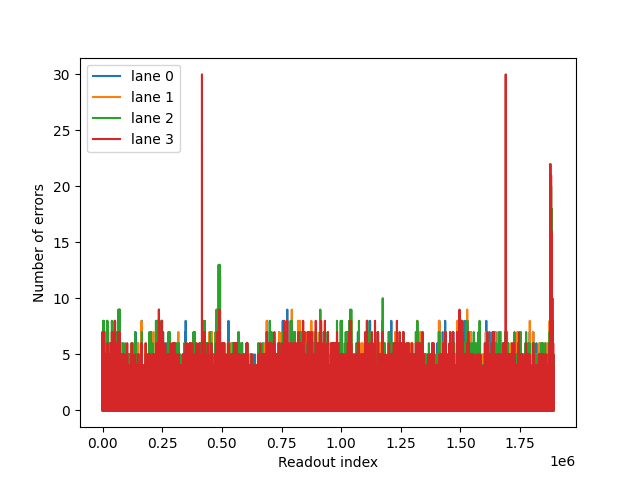

Text(0, 0.5, 'Number of errors')

In [102]:
figure()
for lane in range(4):
    y = readout[lane,...].flatten()
    x = np.arange(len(y))
    plot(y, '-', label=f'lane {lane}')

legend()
xlabel('Readout index')
ylabel('Number of errors')

<IPython.core.display.Javascript object>


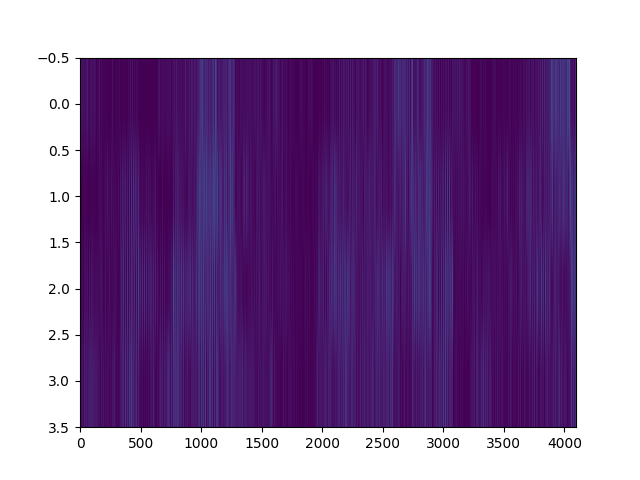

In [103]:
figure()
imshow(readout.reshape(4,-1)[:,:4096], aspect='auto')


In [104]:
readout.shape # (lane, beam, icy, icx, nfinechan, clk, complx)

(4, 144, 9, 9, 9, 9, 2)

In [105]:
readout_lanesum = readout.sum(axis=0).reshape(144*9, -1)
#readout_lanesum = readout.reshape(144*9, -1)



<IPython.core.display.Javascript object>


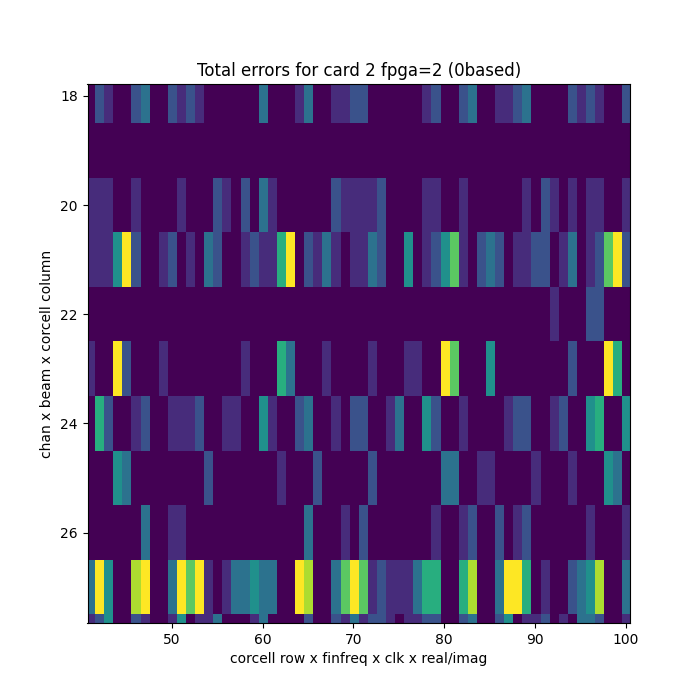

Text(0.5, 1.0, 'Total errors for card 2 fpga=2 (0based)')

In [106]:
figure()
gcf().set_size_inches((7,7))
imshow(readout_lanesum, vmax=8, aspect='auto')
xlabel('corcell row x finfreq x clk x real/imag')
ylabel('chan x beam x corcell column')
title(f'Total errors for card {icard} fpga={ifpga} (0based)')

<IPython.core.display.Javascript object>


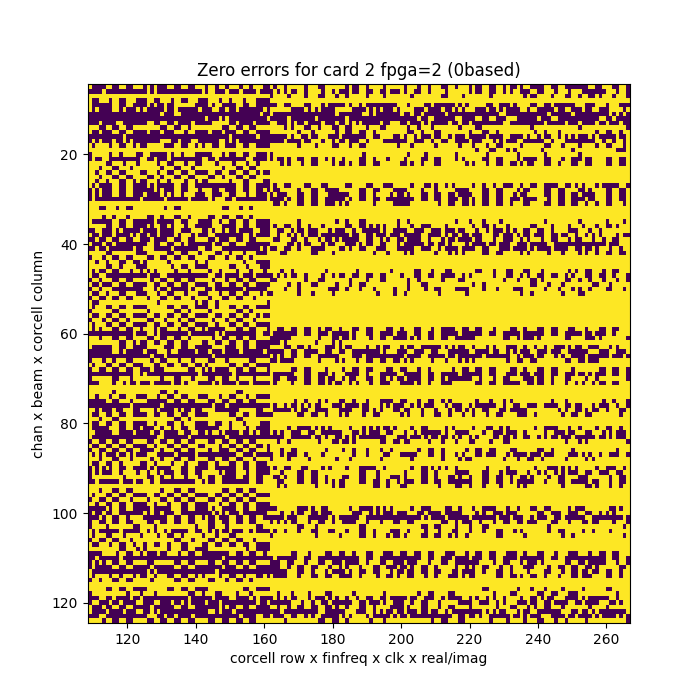

Text(0.5, 1.0, 'Zero errors for card 2 fpga=2 (0based)')

In [115]:
figure()
gcf().set_size_inches((7,7))
imshow(readout_lanesum==0, aspect='auto')
xlabel('corcell row x finfreq x clk x real/imag')
ylabel('chan x beam x corcell column')
title(f'Zero errors for card {icard} fpga={ifpga} (0based)')

<IPython.core.display.Javascript object>


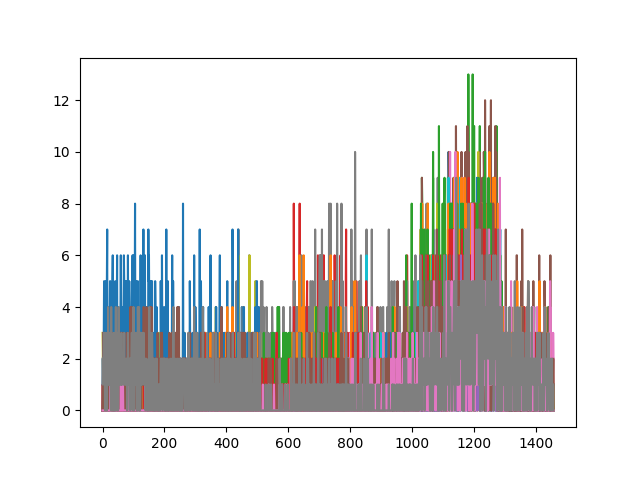

In [110]:
figure()
plot(readout_lanesum[19::72].T)

<IPython.core.display.Javascript object>


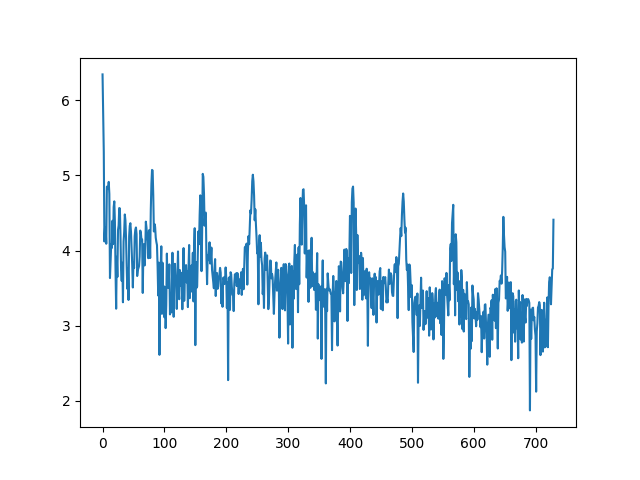

In [111]:
figure()
plot(np.log10(abs(np.fft.rfft(readout_lanesum.sum(axis=0)))))

<IPython.core.display.Javascript object>


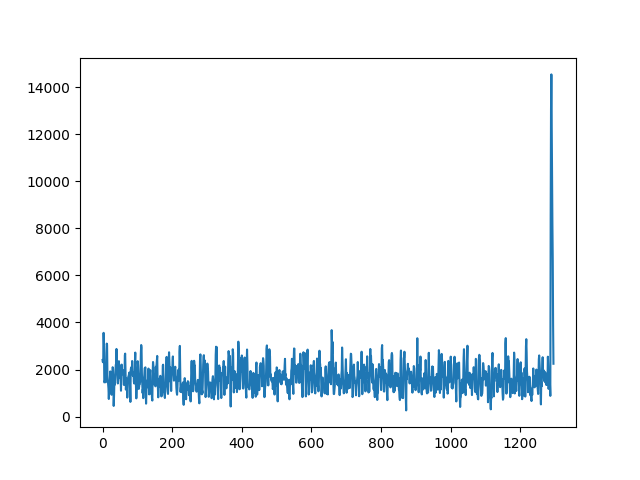

In [112]:
figure()
plot(readout_lanesum.sum(axis=1))

<IPython.core.display.Javascript object>


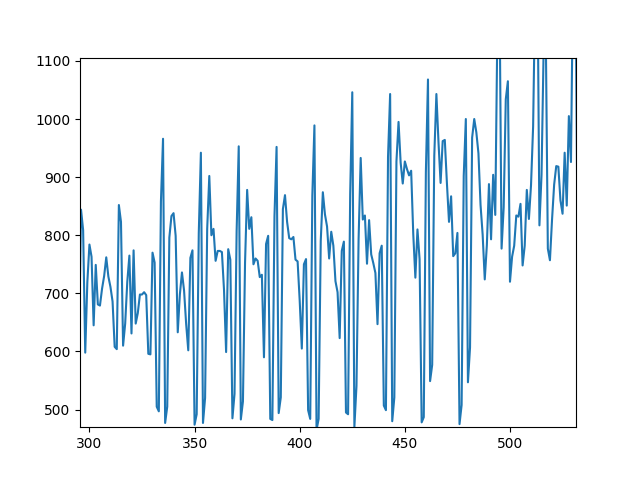

In [113]:
figure()
plot(readout_lanesum.sum(axis=0))